In [1]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout,
                        circuit_drawer)
from qiskit.circuit.library import QFT
from math import (log,ceil)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
import networkx as nx
mpl.rcParams['figure.figsize'] = 11,8
mpl.rcParams.update({'font.size' : 15})

# 0 - Functions

In [2]:
def circulant_adjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A, marked, t): #---
    Oracle = np.zeros([N,N])
    for x in marked:
        Oracle[x,x] = 1
    U = expm(1j*(-gamma*A - Oracle)*t)
    return U

def trotter(gamma, N, A, marked, t, n_trotter):
    O = np.zeros([N,N])
    for x in marked:
        O[x,x] = 1
        
    U = matrix_power(expm(1j*(-gamma*A)*t/n_trotter)@expm(1j*(- O)*t/n_trotter), n_trotter)

    return U

In [97]:
def initialCond(string,N,toGate):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg)
    if string == 'H':
        qc.h(qreg)
        return qc
    for x in range(N):
        if string[x] == '1':
            qc.x(qreg[x])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT    '
    qc = transpile(qc)
    return qc

def diagUniOp(N,diagU0,backend,method): 
    qreg = QuantumRegister(N) 
    circ = QuantumCircuit(qreg,name='    UniOp    ') 
    circ.diagonal(diagU0,qreg)  
    circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ 

def contCirc(N,diagUniOp,backend,method,t,initString):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ

def contCircQFT(N,diagUniOp,backend,method,t,initString,approx):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=False,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=True,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ

def runWalkCirc(NCirc,walkU0,walkTime,initString,method,backend):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCirc(NCirc,walkUQiskit,backend,method,walkTime,initString)
    return walkCirc

def runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,backend,approx):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCircQFT(NCirc,walkUQiskit,backend,method,walkTime,initString,approx)
    return walkCirc
    
def runWalkResults(walkCirc,shots):
    walkResult = simul(walkCirc,False,shots)
    correctedResult = { int(k[::-1],2) : v/shots for k, v in walkResult.items()}
    return correctedResult

def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result


In [44]:
def init_state(N,initcond): #generalizar isto ?
    psi0 = np.zeros((N,1))
    if initcond == 'sup':
        psi0[int(N/2)-1] = 1/sqrt(2)
        psi0[int(N/2)] = 1/sqrt(2)
    if initcond== '0':
        psi0[0] = 1
    if initcond== '4':
        psi0[4] = 1
    if initcond== 'mid':
        psi0[ceil(N/2)] = 1
    return psi0

def final_state(Op,psi0):
    psiN = np.dot(Op,psi0)
    return psiN

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) 
    return probs

def runTheoretical(N,U0,initString):
    U = iqft@U0@qft
    initCond = initString
    initState = init_state(N,initCond)
    psiN = final_state(U,initState)
    probvec = prob_vec(psiN,N)
    return probvec

def theoreticalResults(probvec):
    resultDict = {}
    i = 0
    for v in probvec:
        resultDict[i] = v[0]
        i+=1
    return resultDict 

## 1 - Simple Dynamics Experiments


### 1.0 - Influence of Trotter Approximation

In [35]:
#Aproximacao = Trotter

### 1.1 - Cycle Graph and N = 8

In [177]:
#--- Plot with simulation + qiskit (calculate fidelity)
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initString = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

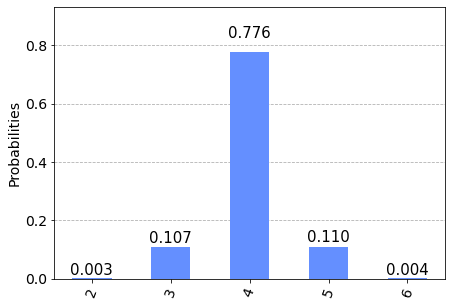

In [167]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [168]:
#walkCirc.draw(output='mpl')

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


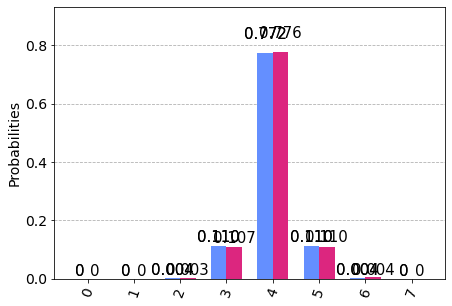

In [169]:
initString = '4'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])
#plot_histogram(resultDict)

#### IBM

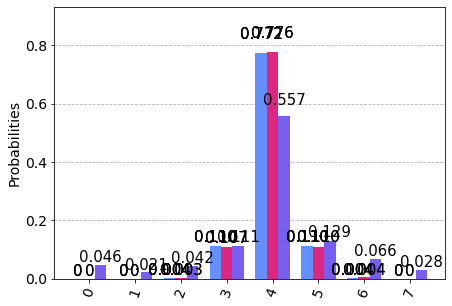

In [170]:
counts = [{'000': 180, '001': 2176, '010': 95, '011': 155, '100': 65, '101': 192, '110': 80, '111': 57}, {'000': 139, '001': 1670, '010': 127, '011': 198, '100': 63, '101': 386, '110': 333, '111': 84},{'000': 100, '001': 740, '010': 257, '011': 240, '100': 131, '101': 783, '110': 595, '111': 154}, {'000': 78, '001': 184, '010': 486, '011': 338, '100': 291, '101': 700, '110': 715, '111': 208}]
ibmResult = { int(k[::-1],2) : v/shots for k, v in counts[1].items()}
plot_histogram([tResults,walkResults,ibmresult])

### 1.2 - Intermediate Graph and N = 8

In [171]:
#--- Plot with simulation + qiskit (calculate fidelity)
initString = '100'
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

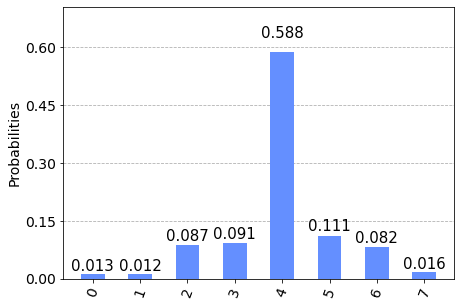

In [172]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


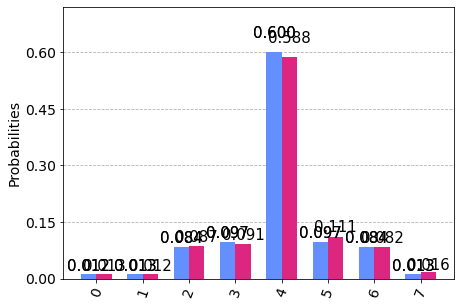

In [173]:
initString = '4'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

### 1.3 - Clique Graph and N = 8

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)
initString = '100'
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

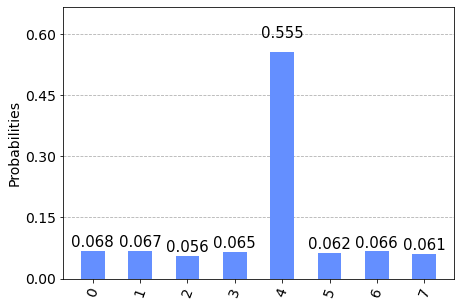

In [176]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


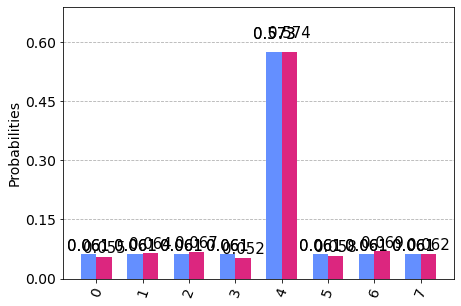

In [86]:
initString = '4'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

### 1.4 - Cycle Graph and N = 16

In [178]:
simulator = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 16
NCirc = 4
initString = '1000'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

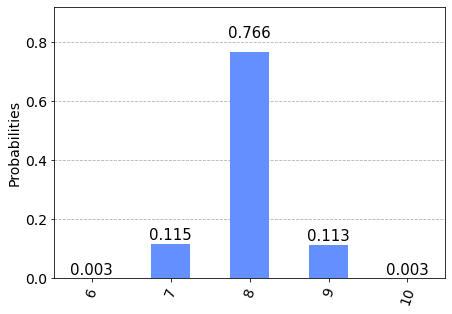

In [179]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


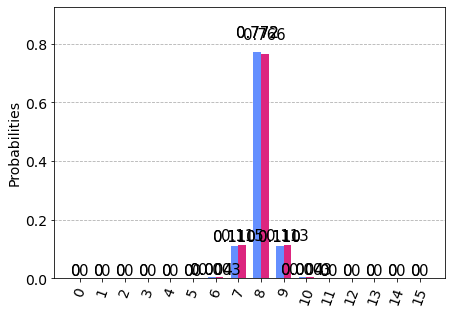

In [180]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [181]:
#--- Plot with simulation + qiskit (calculate fidelity)

### 1.5 - Intermediate Graph and N = 16

In [182]:
initString = '1000'
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

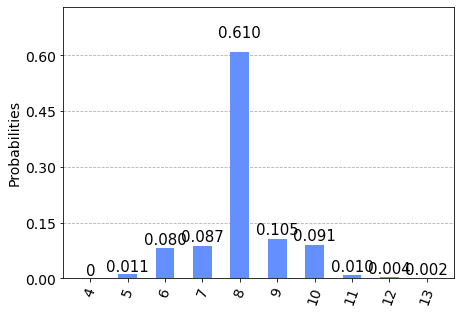

In [163]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


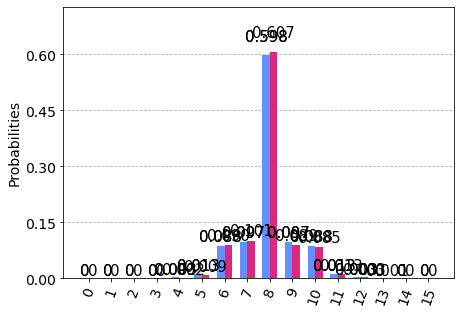

In [158]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [159]:
#--- Plot with simulation + qiskit (calculate fidelity)

### 1.6 - Clique Graph and N = 16

In [183]:
initString = '1000'
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

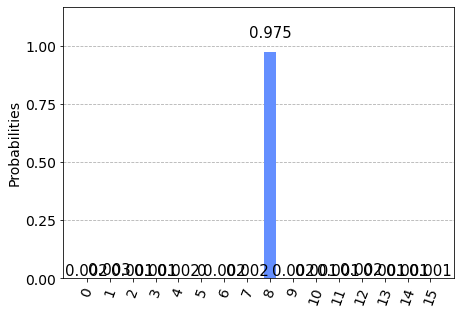

In [184]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


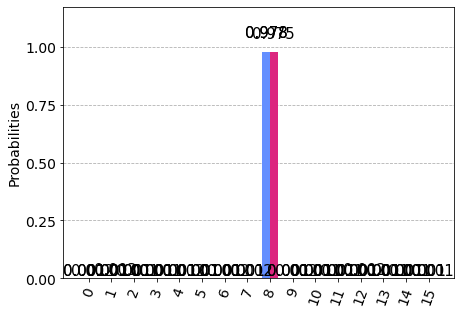

In [185]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [22]:
#--- Plot with simulation + qiskit (calculate fidelity)

## 2 - Dynamics + Fourier Approximation

### 2.1 - Cycle Graph, N = 8 and three/four values for QFT approximation

In [188]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
approxQFT = 1
initString = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

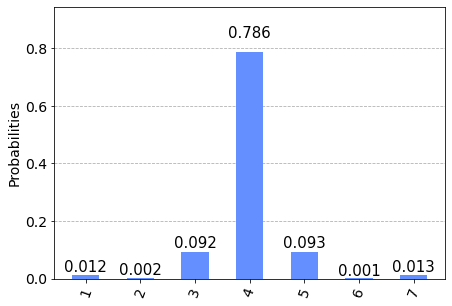

In [189]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [190]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

28


#### Theoretical Vs QFT Approx

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


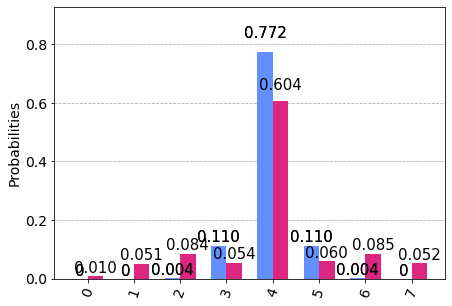

In [201]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.2 - Intermediate Graph, N = 8 and three/four values for QFT approximation

In [202]:
initString = '1000'
approxQFT = 1
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

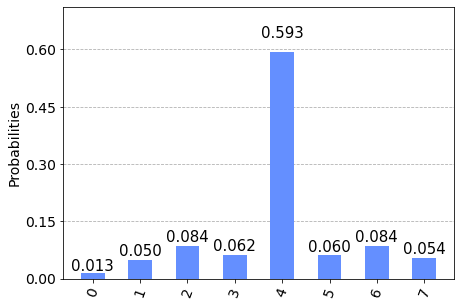

In [203]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [233]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

27


#### Theoretical Vs QFT Approx

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


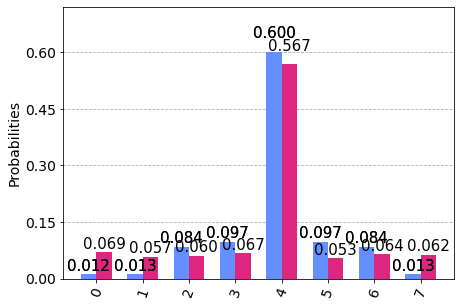

In [234]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.3 - Clique Graph, N = 8 and three/four values for QFT approximation

In [235]:
initString = '1000'
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

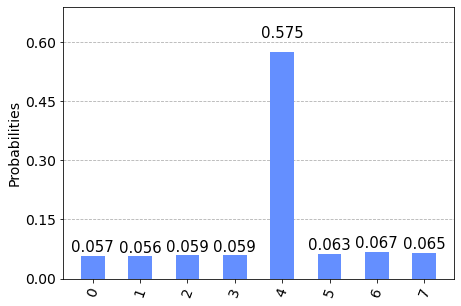

In [236]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [229]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

27


#### Theoretical Vs QFT Approx

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


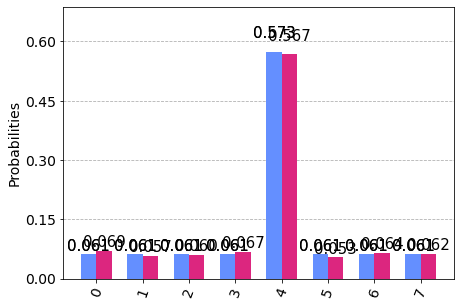

In [232]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.4 - Cycle Graph, N = 16 and three/four values for QFT approximation

In [242]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 16
NCirc = 4
approxQFT = 1
initString = '1000'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

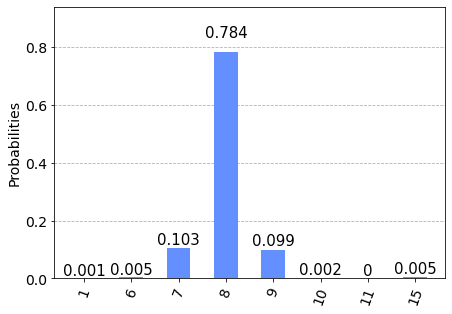

In [243]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [244]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

49


#### Theoretical Vs QFT Approx

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


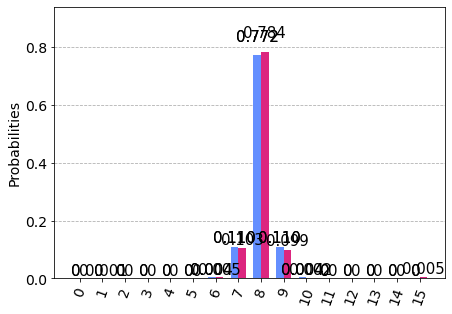

In [245]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.5 - Intermediate Graph, N = 16 and three/four values for QFT approximation

In [251]:
initString = '1000'
approxQFT = 2
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

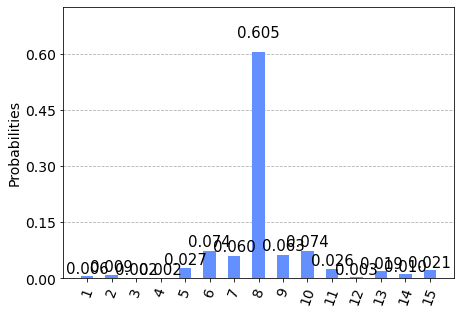

In [252]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [253]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

49


#### T. vs Aprox

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


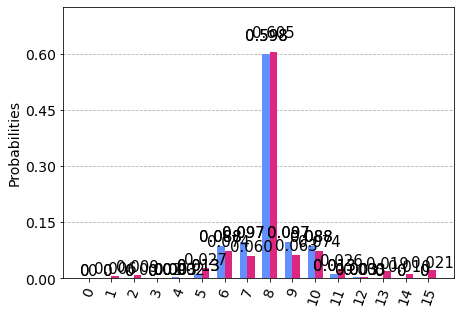

In [254]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.6 - Clique Graph, N = 16 and three/four values for QFT approximation

In [256]:
initString = '1000'
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

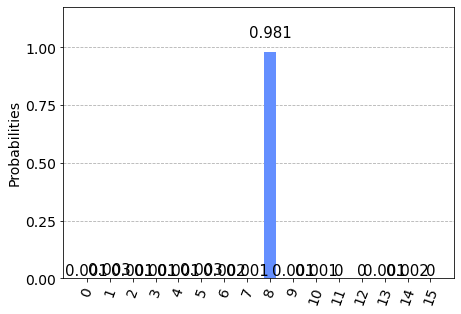

In [257]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [258]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

52


#### T. vs Aprox

<ipython-input-44-d3a774934448>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


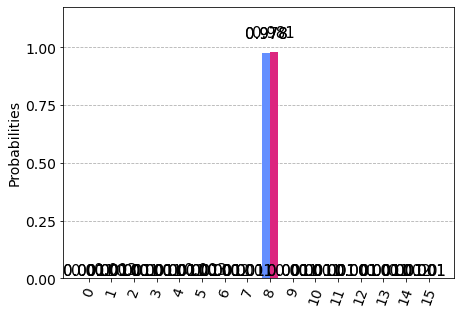

In [259]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

###### 2.7 - Plot Frobenius Norm(QFT - QFT-approx)

###### 2.8 - Number of CNOTS: x_axis: N, y_axis: cx num, and QFT approx

###### 2.9 - Fidelity: x_axis: N, y_axis: fidelity, and QFT approx

## 3 - Searching Problems


###### 3.1 - Clique, N = 8

## Dynamics - Working as intended

In [23]:
backend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initCond = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]

qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft


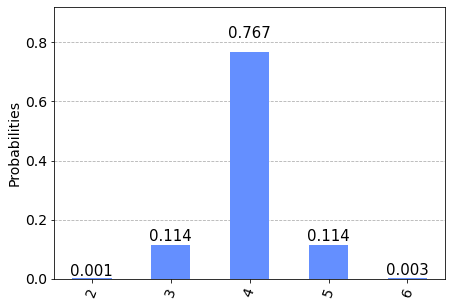

In [24]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkU = np.diag(walkU0).tolist()
walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
walkCirc = contCirc(NCirc,walkUQiskit,backend,method,walkTime,initCond)
walkResult = simul(walkCirc,False,shots)
correctedResult = { int(k[::-1],2) : v/shots for k, v in walkResult.items()}
plot_histogram(correctedResult)

In [260]:
#walkCirc.draw(output='mpl',fold=-1)

## Search without trotter

In [26]:
marked = [0]
gamma = 1 / N
optimalTime = (np.pi/4)*np.sqrt(N)
time = optimalTime
initCondSearch = 'H'
cComplete = [0]+[1 for x in range(N-1)]
searchA = circulant_adjacency(N,cComplete)
#print(A)
searchLambdA =  iqft@A@qft

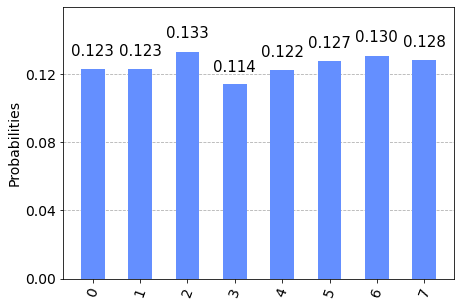

In [27]:
searchU0 = unitary_ctqw(gamma, N, searchLambdA, marked, time)
searchU = np.diag(searchU0).tolist()

searchUQiskit = diagUniOp(NCirc,searchU,backend,method)
searchCirc = contCirc(NCirc,searchUQiskit,backend,method,time,initCondSearch)
searchResult = simul(searchCirc,False,shots)
correctedResult = { int(k[::-1],2) : v/shots for k, v in searchResult.items()}
plot_histogram(correctedResult)

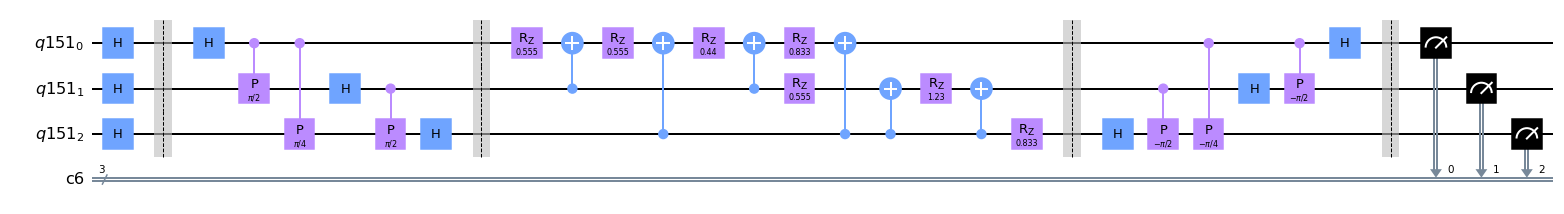

In [28]:
searchCirc.draw(output='mpl',fold=-1)

## Search with trotter

In [ ]:
def trotter(gamma, N, A, marked, t, n_trotter):
    O = np.zeros([N,N])
    for x in marked:
        O[x,x] = 1
    U = matrix_power(expm(1j*(-gamma*A)*t/n_trotter)@expm(1j*(- O)*t/n_trotter), n_trotter)
    return U

In [ ]:
markedTrotter = [5]
gammaTrotter = 1 / N
optimalTimeTrotter = (np.pi/4)*np.sqrt(N)
timeTrotter = optimalTimeTrotter + 16
initCondSearchTrotter = 'H'
cCompleteTrotter = [0]+[1 for x in range(N-1)]
trotterA = circulant_adjacency(N,cCompleteTrotter)
#print(A)
trotterLambdA = iqft@trotterA@qft

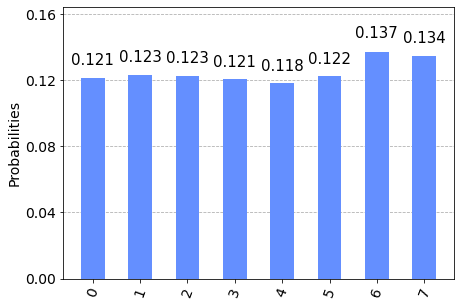

In [ ]:
trotterU0 = trotter(gammaTrotter, N, trotterLambdA, markedTrotter, timeTrotter,n_trotter=1)
trotterU = np.diag(trotterU0).tolist()

trotterUQiskit = diagUniOp(NCirc,trotterU,backend,method)
trotterCirc = contCirc(NCirc,trotterUQiskit,backend,method,timeTrotter,initCondSearchTrotter)
trotterResult = simul(trotterCirc,False,shots)
correctedResult = { int(k[::-1],2) : v/shots for k, v in trotterResult.items()}
plot_histogram(correctedResult)

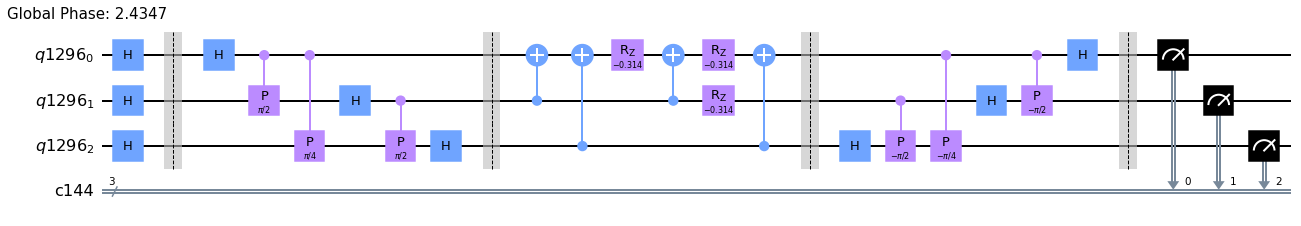

In [ ]:
trotterCirc.draw(output='mpl',fold=-1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=310ee9c0-63b0-42ca-8b6a-c5ec66791c08' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>